In [1]:
import cv2
!pip install matplotlib
!pip install numpy
!pip install scipy
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import time
import random
import math
from scipy.interpolate import CubicSpline
from scipy.interpolate import splprep, splev

In [37]:
print(cv2.__version__)

4.2.0


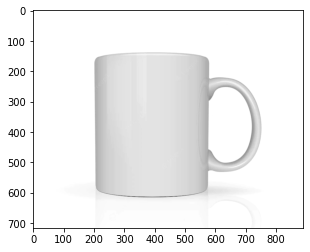

In [300]:
# Lendo a imagem e colocando em tons de cinza
img = cv2.imread('./mug.png')  
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_blur = cv2.GaussianBlur(img, (1,1), 0) 
plt.imshow(img, cmap='gray')


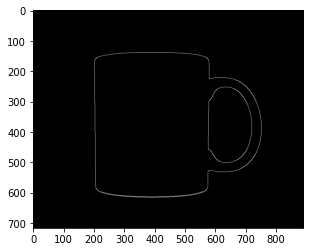

In [301]:
# Obtendo uma imagem binária (preta e branca) com as bordas da caneca
edges = cv2.Canny(image=img, threshold1=100, threshold2=200) 
plt.imshow(edges, cmap='gray')

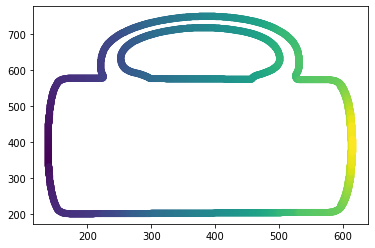

In [302]:
# Obtendo os pontos a partir do algoritmo Canny
pointsx = []
pointsy = []
colors = []
def add(i, j):
    pointsx.append(i)
    pointsy.append(j)
    if(len(colors) == 0):
        colors.append(0)
    else:
        colors.append(colors[-1]+1)
    
for i in range(0, len(edges),1):
    for j in range(0, len(edges[i]),1):
        if(edges[i][j] == 255):
            add(i,j)
            
plt.scatter(pointsx, pointsy, c=colors, cmap='viridis')

In [303]:
def get_tg(p_, _p):
    if _p[0]-p_[0] == 0:
        return 0
    return (_p[1] - p_[1]) / (_p[0]- p_[0])

In [357]:
# Tangents
tgs  = [get_tg((pointsx[0], pointsy[0]), (pointsx[2], pointsy[2]))]
for i in range(1, len(pointsx)-1):
    pp = (pointsx[i-1], pointsy[i-1])
    pn = (pointsx[i+1], pointsy[i+1])
    tgs.append(get_tg(pp, pn))

tgs.append(get_tg((pointsx[-1], pointsy[-1]), (pointsx[-3], pointsy[-3])))


[139, 333, 0] 139 334


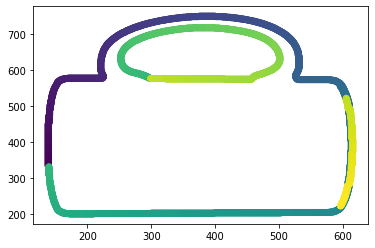

In [346]:
pts_tp =[]
for i in range(0, len(pointsx)):
    pts_tp.append([pointsx[i], pointsy[i], tgs[i]])
    
visited = []
ordered = []
current = pts_tp.pop(0)
current0 = current
colors = []

# ordered.append(current)


while(len(pts_tp) > 0):

    nearest_point_distance = None
    nearest_point = None
    
    visited.append(current)
    for pn in pts_tp:
        dist = np.sqrt((pn[0]-current[0])**2+ (pn[1]-current[1])**2)
        if (nearest_point_distance == None) or (( dist < nearest_point_distance)):
#             print("Current: ", current)
#             print("\tNew: ", dist, "| point: ", pn, "\n")
            nearest_point_distance = dist
            nearest_point = pn

    ordered.append(nearest_point)
    current = pts_tp.pop(pts_tp.index(nearest_point))
    
ordered_scatter = [[],[],[],[]]
c=0
for pn in ordered:
    c += 1
    ordered_scatter[0].append(pn[0])
    ordered_scatter[1].append(pn[1])
    ordered_scatter[2].append(c)
    ordered_scatter[3].append(pn[2])


print(current0, ordered_scatter[0][0], ordered_scatter[1][0])
plt.scatter(ordered_scatter[0], ordered_scatter[1], c=ordered_scatter[2], cmap='viridis')

In [348]:
# Função que retorna um array de pontos mais "importantes"
# A partir do cálculo da curvatura de cada ponto
def get_curvature(xv, yv, threshold = 2*np.pi/3):
    # curvature, using p(i), p(i-1) and p(i+1)
    curvature_points = [[],[],[],[]]
    MAX = 0
    col = 0
    max_pt = [1,1]
    for i in range(1, len(xv)-2):
        x = xv[i]
        y = yv[i]

        xn = xv[i+1]
        yn = yv[i+1]

        xp = xv[i-1]
        yp = yv[i-1]

        angle = (np.arccos(
            (((xp - x)*(xn - x))+((yp - y)*(yn - y)))/(np.hypot(xp-x, yp-y)* np.hypot(xn-x, yn-y))
        ))
        
        curvature_points[3].append(get_tg((xp,yp),(xn,yn)))
            
        if angle < threshold:
            if(angle > MAX):
                MAX = angle
                max_pt[0] = x
                max_pt[1] = y
            curvature_points[0].append(x)
            curvature_points[1].append(y)
            curvature_points[2].append(col)
            col +=1
            
    return np.array(curvature_points), max_pt

In [349]:
points, MAX = get_curvature(ordered_scatter[0], ordered_scatter[1])

<ipython-input-348-2b2a826d1596>:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(curvature_points), max_pt


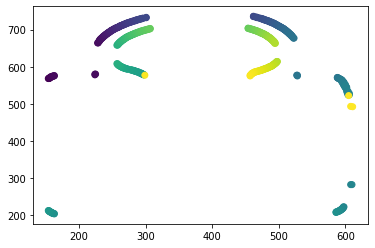

In [350]:
plt.scatter(points[0], points[1], c=points[2], cmap='viridis')

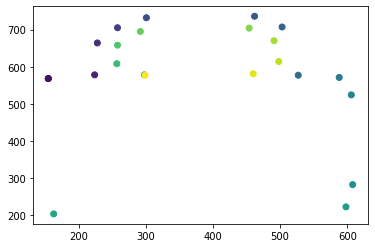

In [351]:
i = 1
p = (points[0][i], points[1][i], points[3][i])
to_scat = [[p[0]],[p[1]],[p[2]], [1]]
c =1
while (i <= len(points[0])-2):
    p_ = (points[0][i], points[1][i], points[3][i])
    dist = np.sqrt(((p_[0]-p[0])**2)+((p_[1]-p[1])**2))    
#    print("Tg: "+ str(abs(p[2]-p_[2])) + " D: " + str(dist) + " C: " + str(c))
    if(dist > 50) or (abs(p[2]-p_[2])> 15):
        c+=1
        to_scat[0].append(p[0])
        to_scat[1].append(p[1])   
        to_scat[3].append(c)
        p = p_
    i += 1
        

plt.scatter(to_scat[0], to_scat[1], c=to_scat[3])

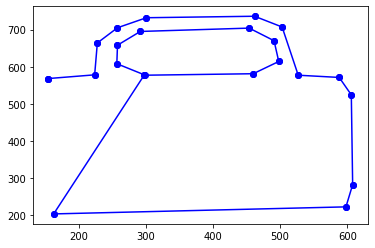

In [355]:
for i in range(len(to_scat[0])-1):
    plt.plot([to_scat[0][i], to_scat[0][i+1]], [to_scat[1][i], to_scat[1][i+1]], 'bo', linestyle="-")

In [356]:
# ordered_scatter = [to_scat[0],to_scat[1],to_scat[3]]
# print(ordered_scatter[0])
# c=0
# for pn in to_scat:
#    c += 1
#     ordered_scatter[0].append(pn[0])
#     ordered_scatter[1].append(pn[1])
#     ordered_scatter[2].append(c)

# _, pimg = plt.subplots()
# _, pcanny = plt.subplots()
# _, pborder = plt.subplots()
# _, pcurvature = plt.subplots()
# _, pspline = plt.subplots()

# pimg.imshow(img, cmap='gray')
# pimg.set_title("Raw image")
# pcanny.imshow(edges, cmap='gray')
# pcanny.set_title("Canny algorithm")
# pborder.scatter(ordered_scatter[1], ordered_scatter[0], c=ordered_scatter[2], cmap='viridis')
# pborder.set_title("Ordered")
# pcurvature.scatter(points[1], points[0])
# pcurvature.set_title("Curvature points")
# pspline.set_title("Cubic spline")




# Calculando as splines dos pontos
# Como o algoritmo funciona apenas com o X em ordem crescente 
# algumas gambiarras foram feitas

# init = 0
# end = 0
# counter = 0
# size = len(ordered_scatter[0])
# print

# def invert_plot(counter):
#     init = counter
#     xn = ordered_scatter[0][counter]
#     while (xn > ordered_scatter[0][counter+1] and counter < size-2):
#         xn = ordered_scatter[0][counter+1]
#         counter = counter + 1       

#     x = ordered_scatter[0][init:counter+2]
#     y = ordered_scatter[1][init:counter+2]
#     return init, counter
           
# while counter < size:
#     xn = ordered_scatter[0][counter]
#     if not(xn >= end):
#         x = ordered_scatter[0][init:counter]
#         y = ordered_scatter[1][init:counter] 
#         if(len(x) < 2):
#             print("Finished")
#             break
#         xs = np.arange(x[0],x[-1], 0.1)
#         cs = CubicSpline(x,y)
#         plt.plot(cs(xs), xs ,color='red')
#         # INVERTING
#         prev_x = x[-1]
#         prev_y = y[-1]
#         init, counter = invert_plot(counter)
#         x = ordered_scatter[0][init-1:counter]
#         y = ordered_scatter[1][init-1:counter]
#         init = counter+1  
#         if(len(x) < 2):
#             print("Breaking")
#             print("Counter: ", counter, " Size : ", len(ordered_scatter[0]))
#             break
#         cs = CubicSpline(x[::-1],y[::-1])
#         xs = np.arange(x[-1],x[0], 0.1)
#         plt.plot(cs(xs), xs, color='red')   
#     else:
#         end = xn
#     counter +=1